# Elastic Net Regression for Rogue Wave Prediction

In this notebook, we model rogue wave occurrence as a linear regression problem using an Elastic Net model. Elastic Net combines the strengths of both Lasso (L1) and Ridge (L2) regularization, making it particularly suitable for datasets with highly correlated input features. The L1 component encourages sparsity by shrinking some coefficients to zero, effectively performing feature selection. The L2 component adds stability by penalizing large coefficients and handling multicollinearity better than Lasso alone. This combination allows the model to balance interpretability, generalization, and robustness.

We start with a linear model because it offers a clear and direct interpretation of feature effects on the target variable. Unlike more complex nonlinear models, linear regression makes it easy to understand how each input contributes to the predicted wave height. This interpretability is valuable for domain experts aiming to gain physical insights from the model.

Before training, we standardize the input features using `StandardScaler`, since linear models are sensitive to the scale of input variables. Proper scaling ensures that all features contribute comparably to the optimization process, especially when regularization is applied.

Hyperparameter tuning is performed using k-fold cross-validation with a stratified splitting strategy. Stratification ensures that the rare rogue wave events are well represented in each fold, which is important for stable performance evaluation and fair training-validation distribution.

We optimize the following hyperparameters to ensure the Elastic Net model is both accurate and well-regularized:
- `alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]`: Controls the overall strength of regularization. Larger values lead to greater shrinkage of coefficients. We explore a logarithmic range from 0.0001 to 10 to allow both weak and strong regularization regimes to be tested.
- `l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]`: Determines the trade-off between L1 (Lasso) and L2 (Ridge) regularization. A value of 0 corresponds to pure Ridge, 1 to pure Lasso, and values in between yield Elastic Net behavior. By testing a range from 0.1 to 1.0, we explore models that vary from dense to sparse, allowing us to balance feature selection and stability.
- `max_iter = 5000`: Ensures sufficient iterations for convergence during coordinate descent optimization.
- `tol = [1e-3, 1e-4]`: Sets the convergence threshold. We test both 1e-3 and 1e-4 to ensure numerical stability without excessive computation.
- `selection = ['cyclic', 'random']`: Specifies the update rule for coordinate descent. 'cyclic' iterates through features in a fixed order, while 'random' selects features randomly. Testing both allows us to assess potential effects on convergence and performance.

To evaluate model performance, we compute multiple regression metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), R² score, and Spearman correlation. MSE penalizes large errors more severely and is sensitive to outliers, while MAE provides a more robust measure of average prediction error. The R² score indicates how much variance in the target is explained by the model, and Spearman correlation assesses whether the model preserves the rank ordering of the predictions, a useful complement to R² when dealing with non-linearities or monotonic relationships.

We complement our performance analysis with model interpretability techniques. First, we examine the learned model coefficients to assess global feature importance and determine which variables the model relies on most. Second, we apply SHAP (SHapley Additive exPlanations) using the `LinearExplainer` with `feature_perturbation="correlation_dependent"` mode. This setting is particularly appropriate for linear models trained on correlated features, as it accounts for statistical dependence between variables when computing feature contributions.

To ensure robust and consistent explanations, we compute SHAP values for both the training and test datasets. SHAP values on the training set reflect what the model has learned during optimization, while the test set SHAP values reveal how the model generalizes to unseen data. Comparing the two provides insight into the stability and reliability of the model’s learned feature relationships, and helps identify potential overfitting or shifts in feature importance.

In [1]:
%load_ext autoreload
%autoreload 2

**Imports**

In [2]:
import os
import sys
import shap
import pickle

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

import matplotlib.pyplot as plt

sys.path.append('./')
sys.path.append('../scripts/')
import utils

import warnings
warnings.filterwarnings("ignore")

**Parameter Settings**

In [3]:
n_jobs = 4
print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

Using 4 cores from 8 available cores.


In [4]:
seed = 42
num_cv = 5

In [5]:
hyperparameter_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_iter': [5000],
    'tol': [1e-3, 1e-4],
    'selection': ['cyclic', 'random'],
}

**Data Loading**

We load the data that was preprocessed in `01_data_processing.ipynb`.  

In [6]:
file_data = "../data/data_train_test.pickle"  # path to the preprocessed data
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(file_data)

Loading data...

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})


**Data Standardization**

In [7]:
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

**Model Training**

In [8]:
# Run CV
regressor = ElasticNet(random_state=seed)
model, cv_results = utils.run_CV(regressor, hyperparameter_grid, num_cv, X_train_transformed, y_train_cat, y_train, n_jobs)

In [ ]:
cv_results.sort_values(by="score", ascending=False, inplace=True)

file_cv = f"../results/linear_regression/cv_results.csv"
cv_results.to_csv(file_cv)

cv_results

,alpha,l1_ratio,max_iter,selection,tol,score
1,0.0001,0.1,5000,cyclic,0.0001,0.062778
0,0.0001,0.1,5000,cyclic,0.0010,0.062778
3,0.0001,0.1,5000,random,0.0001,0.062778
2,0.0001,0.1,5000,random,0.0010,0.062778
5,0.0001,0.3,5000,cyclic,0.0001,0.062772
...,...,...,...,...,...,...
105,1.0000,0.5,5000,cyclic,0.0001,-0.000002
106,1.0000,0.5,5000,random,0.0010,-0.000002
107,1.0000,0.5,5000,random,0.0001,-0.000002
109,1.0000,0.7,5000,cyclic,0.0001,-0.000002


**Model Evaluation**

Evaluate on Training Set


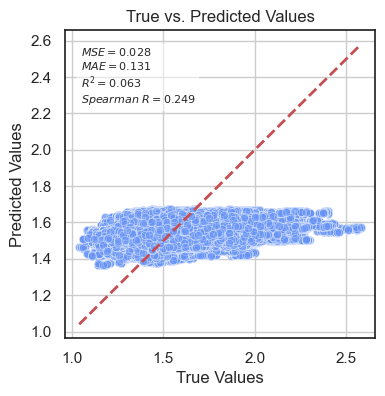

Evaluate on Test Set


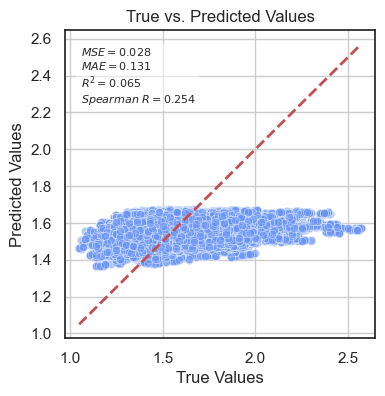

In [10]:
# Evaluate model on train and test set
utils.evaluate_best_regressor(model, X_train_transformed, y_train, dataset="Training", plot=True)
utils.evaluate_best_regressor(model, X_test_transformed, y_test, dataset="Test", plot=True)

In [ ]:
# Save the model
data_train = pd.DataFrame(X_train_transformed, columns=X_train.columns)
data_train["AI_10min"] = y_train
data_train["AI_10min_cat"] = y_train_cat

data_test = pd.DataFrame(X_test_transformed, columns=X_test.columns)
data_test["AI_10min"] = y_test
data_test["AI_10min_cat"] = y_test_cat

data_and_model = [data_train, data_test, model]

file_data_model = f"../results/linear_regression/model_and_data.pickle"
with open(file_data_model, 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

utils.get_model_size(model)

Model size on disk: 0.0000 GB


**Model Interpretation**

Interpretation on Training Set

In [ ]:
# Set up SHAP explainer with whole training data as background dataset
explainer = shap.LinearExplainer(model=model, masker=shap.maskers.Independent(X_train_transformed, max_samples=X_train_transformed.shape[0]), data=X_train_transformed, feature_perturbation="correlation_dependent")

# Base value (model expected value)
expected_value = model.predict(X_train_transformed).mean()

# Create SHAP Explanation
explanation_train = shap.Explanation(
    values=explainer.shap_values(X_train_transformed),
    base_values=np.full(len(X_train_transformed), expected_value),
    data=X_train_transformed,
    feature_names=X_train.columns.tolist(),
)

# Save object to a pickle file
file_shap = f"../results/linear_regression/train_shap.pkl"
with open(file_shap, "wb") as f:
    pickle.dump(explanation_train, f)

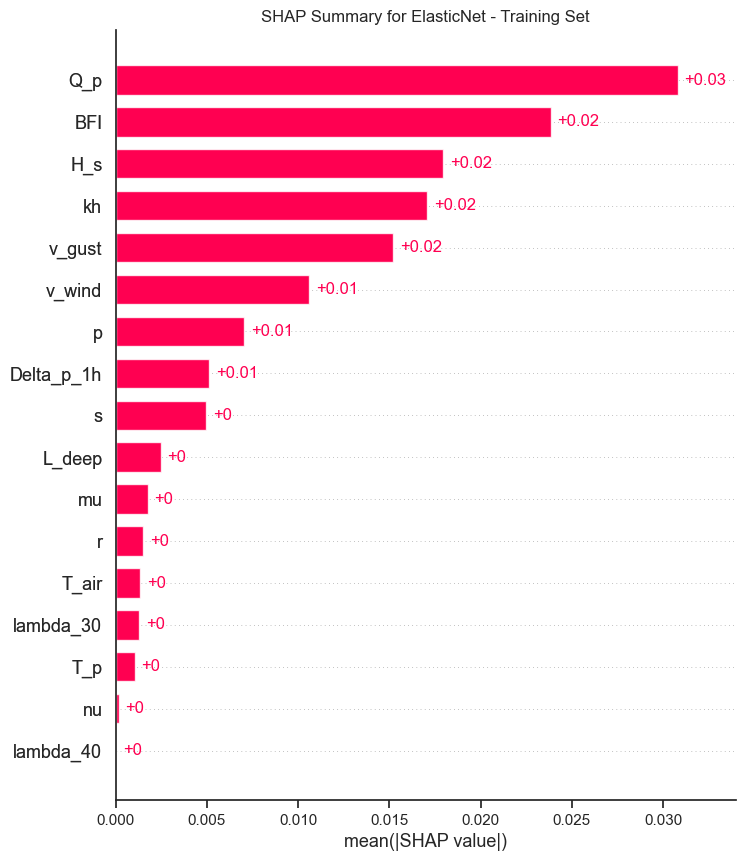

In [13]:
shap.plots.bar(explanation_train, max_display=17, show=False)
plt.title("SHAP Summary for ElasticNet - Training Set")
plt.show()

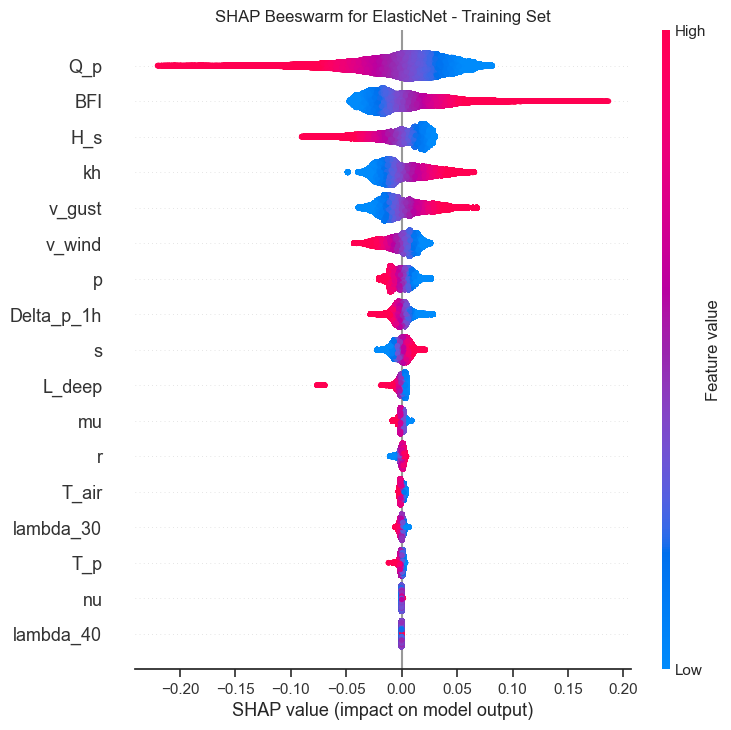

In [14]:
shap.plots.beeswarm(explanation_train, max_display=17, show=False)
plt.title("SHAP Beeswarm for ElasticNet - Training Set")
plt.show()

In [ ]:
# Set up SHAP explainer with whole training data as background dataset
explainer = shap.LinearExplainer(model=model, masker=shap.maskers.Independent(X_train_transformed, max_samples=X_train_transformed.shape[0]), data=X_train_transformed, feature_perturbation="correlation_dependent")

# Base value (model expected value)
expected_value = model.predict(X_test_transformed).mean()

# Create SHAP Explanation
explanation_test = shap.Explanation(
    values=explainer.shap_values(X_test_transformed),
    base_values=np.full(len(X_test_transformed), expected_value),
    data=X_test_transformed,
    feature_names=X_test.columns.tolist(),
)

# Save object to a pickle file
file_shap = f"../results/linear_regression/test_shap.pkl"
with open(file_shap, "wb") as f:
    pickle.dump(explanation_test, f)

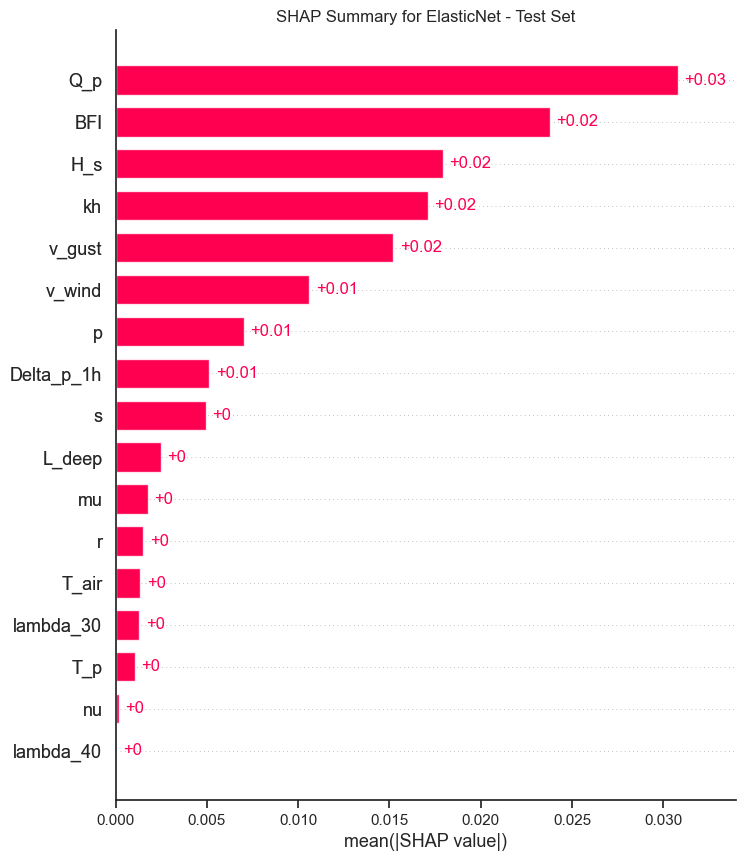

In [16]:
shap.plots.bar(explanation_test, max_display=17, show=False)
plt.title("SHAP Summary for ElasticNet - Test Set")
plt.show()

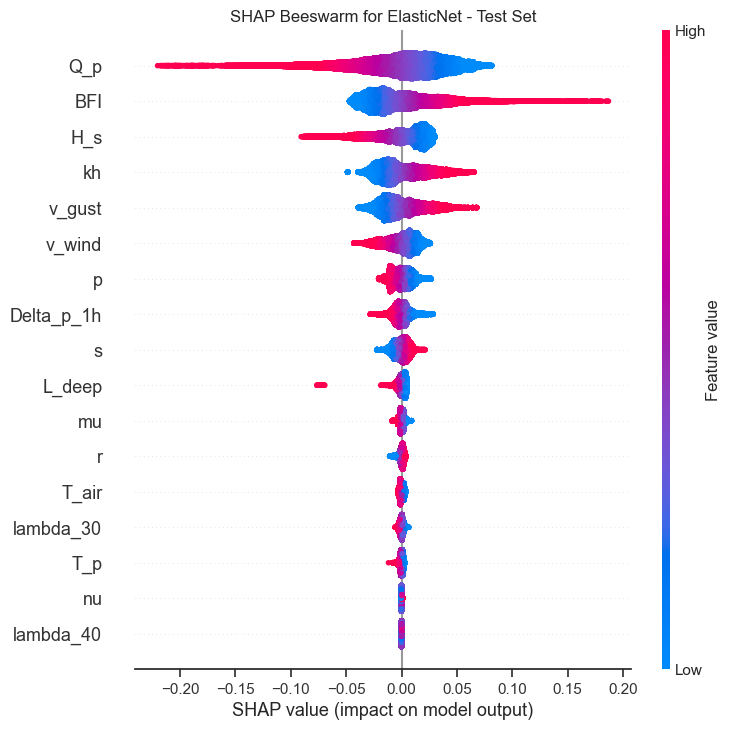

In [17]:
shap.plots.beeswarm(explanation_test, max_display=17, show=False)
plt.title("SHAP Beeswarm for ElasticNet - Test Set")
plt.show()

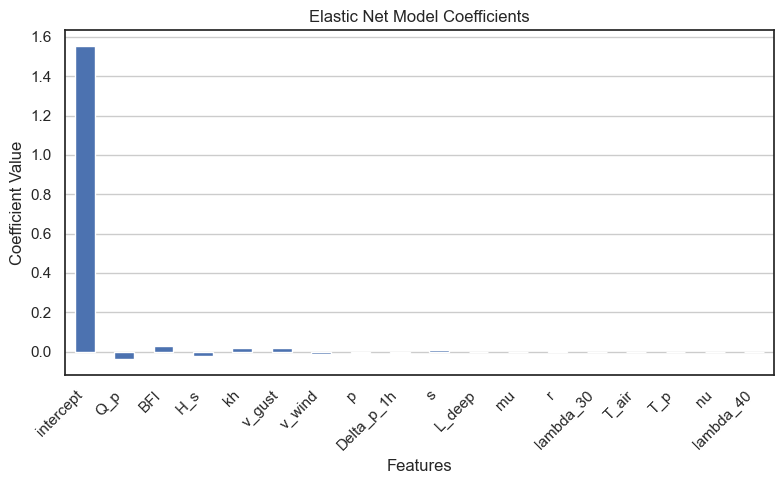

In [18]:
# Feature importance based on model coefficients
feature_importance = pd.DataFrame(model.coef_, index=X_train.columns, columns=["Coefficient"])
feature_importance.loc["intercept", "Coefficient"] = model.intercept_
feature_importance = feature_importance.sort_values(by="Coefficient", ascending=False, key=abs)

# Plotting
plt.figure(figsize=(8, 5))
feature_importance["Coefficient"].plot(kind='bar')
plt.title("Elastic Net Model Coefficients")
plt.ylabel("Coefficient Value")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

Conclusion: The Elastic Net regression model fails to capture meaningful patterns in the data, as indicated by the low predictive performance. The model relies almost entirely on the intercept, while all feature coefficients remain close to zero, suggesting that none of the input variables contribute significantly to the prediction. This outcome highlights that linear models like Elastic Net are insufficient for modeling rogue wave formation, which likely involves complex, non-linear feature interactions.